In [1]:
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np
import os
import mytools
import pandas as pd

# Prepare Data

In [2]:
# Read pandas dataframe with all information about sparse training tensors
st_info = pd.read_pickle('/home/majd/sparse_training_tensors/sparse_tensor_info.pk')
st_info.head()

,dir,offset,diff
0,"[-0.4198009988390553, -0.4440823098716106, 0.7...","[-0.13160994280565688, 0.44427934344609393, -2...",0.020573
1,"[0.9292584753858835, 0.36787504773435054, -0.0...","[-2.8848038745477615, -0.18587373584726274, -2...",0.032068
2,"[0.6975108938815566, -0.6644836831430804, 0.26...","[-2.640509097021054, 0.40556093511292457, 0.66...",0.043303
3,"[0.32184656062767913, 0.5144094887414011, 0.79...","[1.5512170253679882, -1.523265044801098, -2.37...",0.025124
4,"[-0.5064111899864489, -0.6946257429389592, -0....","[0.16089299282025019, 2.8954267960229534, 0.37...",0.016838


In [3]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_training_tensors/', st_info=st_info)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(MyDataset,[0.8, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))

# Create DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training samples:  1943113
Validation samples:  485778


# Visualize Data

In [4]:
# Print tensor shapes
for X_plot, y_plot, offset_plot in train_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([64, 1, 120, 120, 120])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])


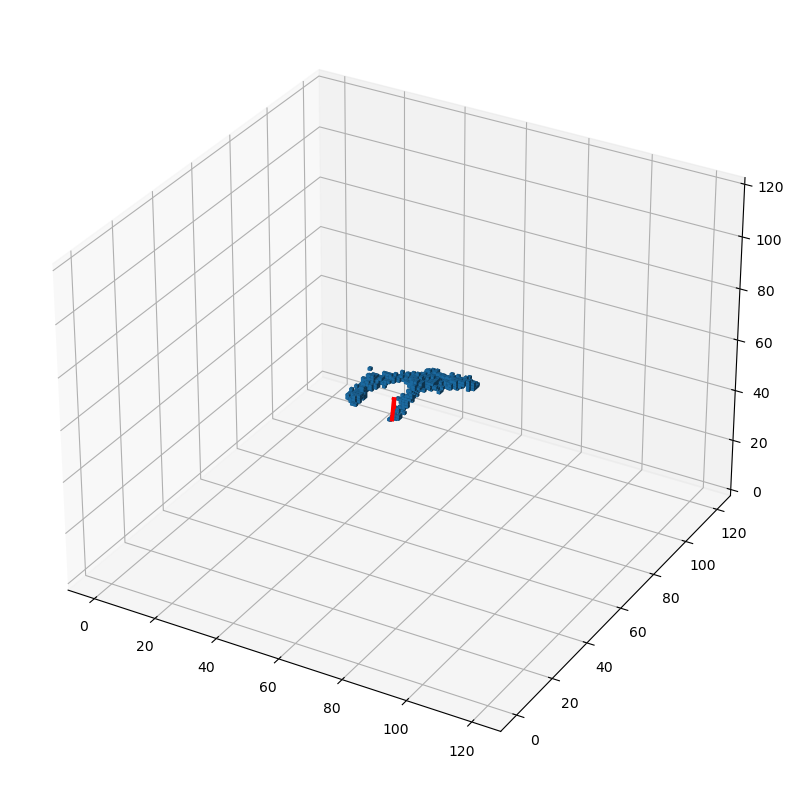

In [5]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = 3.0
# Voxel size in cm
vox_l = 0.05

index = 2
mytools.plot_tensor_dir(tensor = X_plot.to_dense().numpy()[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)

# Define Convnet Architecture

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class Convnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1)
        self.conv3 = nn.Conv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(12**3 *20, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = F.normalize(self.fc3(x),dim=1)
        return x

model = Convnet().to(device)

# Print a nicer model summary
print(model)

Using cuda device
Convnet(
  (conv1): Conv3d(1, 50, kernel_size=(6, 6, 6), stride=(2, 2, 2))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(50, 30, kernel_size=(4, 4, 4), stride=(1, 1, 1))
  (conv3): Conv3d(30, 20, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (fc1): Linear(in_features=34560, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)


# Train the model

In [8]:
# Specify optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.0001, betas=(0.94, 0.999), eps=1e-07)

# Define Loss function
CS = nn.CosineSimilarity()
def loss_fn(output, target):
    loss = torch.mean(-1.0*CS(output,target))
    return loss

In [9]:
# Implement early stopping in training loop
# Stop if validation loss has not decreased for the last [patience] epochs
# The model with the lowest loss is stored
patience = 2

Training_losses = np.array([])
Validation_losses = np.array([])

epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    Training_losses = np.append(Training_losses, mytools.train(train_dataloader, model, loss_fn, optimizer, device))
    Validation_losses = np.append(Validation_losses, mytools.validate(val_dataloader, model, loss_fn, device))
    
    # Keep a running copy of the model with the lowest loss
    if Validation_losses[-1] == np.min(Validation_losses):
        final_model = copy.deepcopy(model)
    
    if len(Validation_losses) > patience:
        if np.sum((Validation_losses[-1*np.arange(patience)-1] - Validation_losses[-1*np.arange(patience)-2]) < 0) == 0:
            print("Stopping early!")
            break
            
print("Done!")

Epoch 1
-------------------------------
Current batch training loss: -0.059040  [    0/1943113]
Current batch training loss: -0.247307  [ 6400/1943113]
Current batch training loss: -0.345230  [12800/1943113]


KeyboardInterrupt: 

# Visualize Training

In [ ]:
# Plot Training and Validation Loss
# Indicate where the final model stopped training

best_epoch = np.argmin(Validation_losses)

plt.plot(np.arange(len(Training_losses)),Training_losses,label="Training Loss")
plt.plot(np.arange(len(Validation_losses)),Validation_losses,label="Validation Loss")
plt.axvline(best_epoch,label="Final model stopped here",color='k')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity Loss')
plt.legend()


# Save the Model

In [ ]:
torch.save(final_model, "../3D_Heteroscedastic_Convnet_models/3D_CNN.pt")
print("Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_CNN.pt")